# VC - Entrega Práctica 3
---
 - Luis Martín Pérez
- Andrea Santana López

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

from scipy.stats import cosine

### TAREA 1 - Detector de dinero en monedas

In [2]:
import cv2
umbral = 200
img = cv2.imread('CoinsImages/Monedas.jpg')
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th,img_th = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)

click_flag = False
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)

circ = cv2.HoughCircles(
        pimg,  # imagen
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 2

money_amount = 0.0
started_count = False
reference_coin_value = 1.0

def identify_coin_value_from_reference_coin(selected_coin_radius, current_coin_radius):
    global reference_coin_value
    if selected_coin_radius == 0:
        return 0.
    size_ratio = current_coin_radius * 2 / float(selected_coin_radius*2)
    scale = float(selected_coin_radius) / min(img.shape[1], img.shape[0])
    if 0.98 <= current_coin_radius / selected_coin_radius <= 1.05:
        return 1.0
    if size_ratio <= 0.66 + scale * current_coin_radius / current_coin_radius:
        return 0.01
    elif size_ratio <= 0.701 + scale * current_coin_radius / current_coin_radius:
        return 0.02
    elif size_ratio <= 0.74 + scale * current_coin_radius / current_coin_radius:
        return 0.1
    elif size_ratio <= 0.8 + scale * current_coin_radius / current_coin_radius:
        return 0.05
    elif size_ratio <= 0.8501 + scale * current_coin_radius / current_coin_radius:
        return 0.2
    elif size_ratio <= 0.95 + scale * current_coin_radius / current_coin_radius:
        return 0.5
    elif size_ratio <= 1.3 + scale * current_coin_radius / current_coin_radius:
        return 2.0
    return 0.

calculated = False
def calculate_coin_amounts(coin_circles, selected_coin_radius):
    global money_amount, calculated
    calculated = True
    for circle_x, circle_y, circle_radius in coin_circles:
        cv2.circle(img, (int(circle_x), int(circle_y)), int(circle_radius*0.3), (0, 30, 240), -1)
        cv2.circle(img, (int(circle_x), int(circle_y)), int(circle_radius*0.3 + 1), (0, 0, 0), 3)
        current_coin_value = identify_coin_value_from_reference_coin(selected_coin_radius, circle_radius)
        money_amount += current_coin_value
        cv2.putText(img, f'Coin: {current_coin_value:.2f}$', (int(circle_x - circle_radius*1.1) , int(circle_y + circle_radius*1.2)), font,
                   fontScale, (255, 0, 0), thickness, cv2.LINE_AA)
    cv2.putText(img, f"Total money amount is: {money_amount:.2f}$", (50, 50), font, fontScale, (255, 0, 0), thickness, cv2.LINE_AA)
    print(f"Total money amount is: {money_amount:.2f}$")


selected_coin_radius = 0
def start_count_on_mouse_click(event, x, y, flags, param):
    global circ, started_count, selected_coin_radius, calculated
    if event == cv2.EVENT_LBUTTONDOWN and not started_count:
        started_count, selected_coin_radius = select_reference_coin(circ[0], x, y, param)
    if started_count and not calculated:
        calculate_coin_amounts(circ[0], selected_coin_radius)


def is_in_bounds(circle_x, circle_y, click_x, click_y, radius):
    return (click_x - circle_x)**2 + (click_y - circle_y)**2 <= radius**2


def select_reference_coin(coin_circles, click_x, click_y, img):
    for circle_x, circle_y, circle_radius in coin_circles:
        if is_in_bounds(circle_x, circle_y, click_x, click_y, circle_radius):
            cv2.putText(img, 'You clicked this', (click_x, click_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
            return True, circle_radius
    return False, 0


window_name = "Monedas"
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, start_count_on_mouse_click, img)

while True:
    cv2.imshow(window_name, img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

Total money amount is: 5.18$


# Clasificador Microplasticos


Total de muestras extraídas: 302

--- Resultados de Random Forest ---
Precisión del clasificador (Test): 0.7912


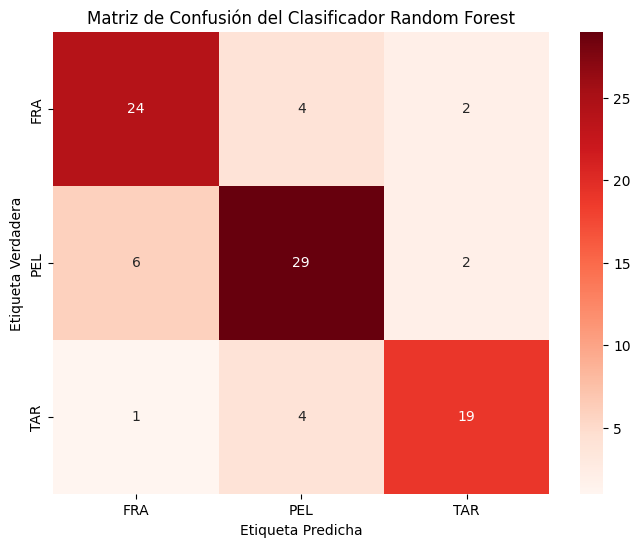

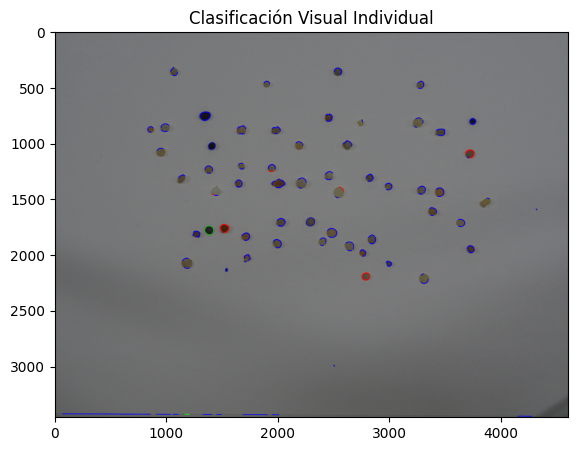

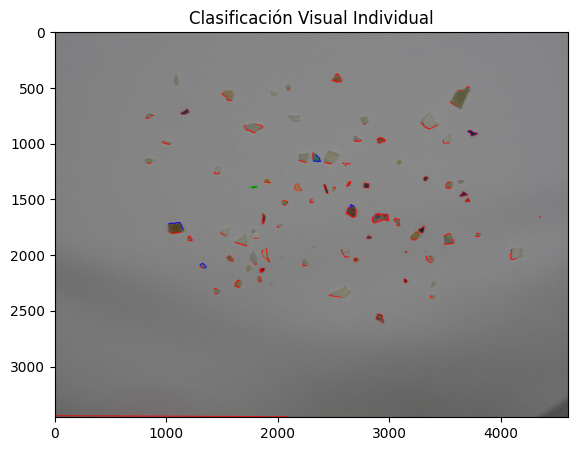

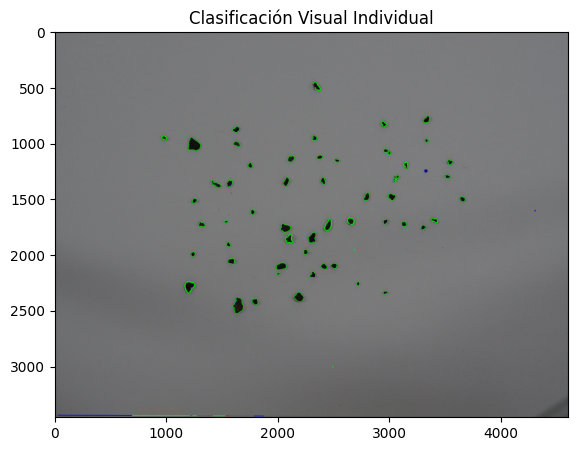

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from pathlib import Path

# --- 1. Inicialización y Carga de Imágenes ---
features_list = []
labels_list = []
label_map = {"FRA": 0, "PEL": 1, "TAR": 2}
reverse_label_map = {v: k for k, v in label_map.items()}

BASE_DIR = Path(__file__).parent if '__file__' in locals() else Path('.')
IMAGE_FOLDER = BASE_DIR / "MicroplasticImages"

# Lista de imágenes a procesar con su etiqueta real
images_data = [
    # Usamos el operador / de pathlib para unir la ruta de forma segura
    {"path": IMAGE_FOLDER / "pellet-03-olympus-10-01-2020.jpg", "label": "PEL"},
    {"path": IMAGE_FOLDER / "fragment-03-olympus-10-01-2020.jpg", "label": "FRA"},
    {"path": IMAGE_FOLDER / "tar-03-olympus-10-01-2020.jpg", "label": "TAR"},
]
# Colores para dibujar microplasticos detectados
color_map_bgr = {
    0: (0, 0, 255),    # FRA (Rojo)
    1: (255, 0, 0),    # PEL (Azul)
    2: (0, 255, 0)     # TAR (Verde)
}
def process_contours(image_path, microplastic_label, is_training):
    img_bgr = cv2.imread(image_path)
    img_with_predictions = img_bgr.copy()

    if img_bgr is None:
        print(f"Error: No se pudo cargar la imagen en {image_path}")
        return

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

    thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 5)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50:
            perimeter = cv2.arcLength(contour, True)

            # === 🔹 Cálculo del color medio del objeto detectado ===
            mask = np.zeros(img_gray.shape, np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_val = cv2.mean(img_bgr, mask=mask)  # (B, G, R, _)
            color_mean = np.mean(mean_val[:3])  # Promedio de los 3 canales

            params = [area, perimeter, color_mean]  # Añadimos color a las features

            if not is_training:
                predict_and_draw_contours(
                    params,
                    rf_model,
                    X.columns,
                    contour,
                    img_with_predictions
                )
            else:
                process_data_training(params, microplastic_label)

    if not is_training:
        plt.figure(figsize=(10, 5))
        plt.title(f"Clasificación Visual Individual")
        plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
        plt.show()


def predict_and_draw_contours(params, classifier, features_cols,contour, img_with_predictions):
      # Crear el dato para la predicción
    new_feature = pd.DataFrame([params], columns=features_cols)

    # Predecir la clase
    predicted_label_code = classifier.predict(new_feature)[0]
    predicted_class = reverse_label_map[predicted_label_code]
    color = color_map_bgr.get(predicted_label_code, (255, 255, 255))

    # Dibuja el contorno del objeto
    cv2.drawContours(img_with_predictions, [contour], -1, color, 3)


def process_data_training(params, microplastic_label):
    #Añadir los datos para el entrenamiento
    features_list.append(params)
    labels_list.append(microplastic_label)


for item in images_data:
    process_contours(item["path"], label_map[item["label"]],True)

# Preparación de Datos y Entrenamiento
X = pd.DataFrame(features_list, columns=['Area', 'Perimetro', 'ColorMean'])
y = pd.Series(labels_list)
print(f"\nTotal de muestras extraídas: {len(X)}")
# División y Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#Entrenamiento de los datos
rf_model.fit(X_train, y_train)

# Predicción y Evaluación
y_pred = rf_model.predict(X_test)
print('\n--- Resultados de Random Forest ---')
print(f"Precisión del clasificador (Test): {accuracy_score(y_test, y_pred):.4f}")

# --- MATRIZ DE CONFUSIÓN ---
cm = confusion_matrix(y_test, y_pred)
class_names = list(label_map.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión del Clasificador Random Forest')
plt.show()
for item in images_data:
    process_contours(item["path"],"",False)